In [3]:
import scipy.stats
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn

# sns.set(style="ticks")
from math import log10

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = 14,12
matplotlib.rcParams['font.weight'] = "medium"

matplotlib.rcParams['axes.labelweight'] = 'medium'
matplotlib.rcParams['figure.titleweight'] = 'medium'
matplotlib.rcParams['axes.titleweight'] = 'medium'

sns.set(font_scale=1.1, style="ticks", font="Lato")

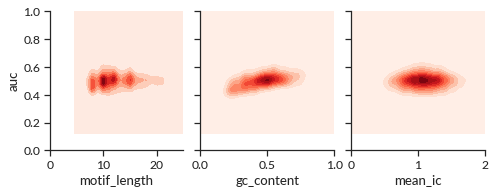

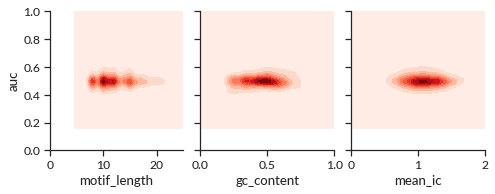

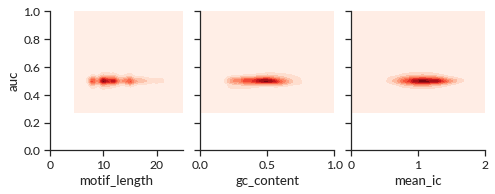

In [20]:
for dataset in ['remap', 'jy10', 'jy50']:
    df = pd.read_csv(f'results/{dataset}/motif_tf_aucs.all.{dataset}.tsv', sep='\t')
    g = sns.PairGrid(df, x_vars=['motif_length', 'gc_content', 'mean_ic'], y_vars=['auc'], aspect=0.9)
    for i in range(len(g.axes)):
        g.axes[0][i].set(ylim=(0,1))
    g.axes[0][0].set(xlim=(0,25))
    g.axes[0][1].set(xlim=(0,1))
    g.axes[0][2].set(xlim=(0,2))
    g.map(sns.kdeplot, shade=True, cmap='Reds');
    g.savefig(f"{dataset}_distplot.all.svg", dpi=300)

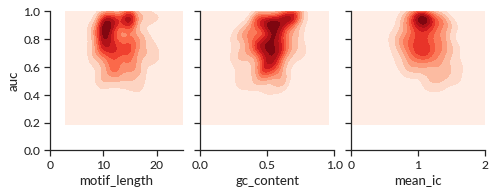

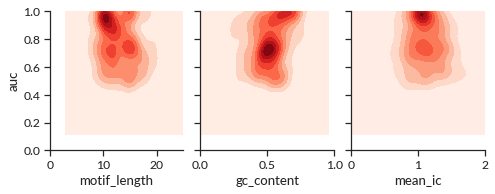

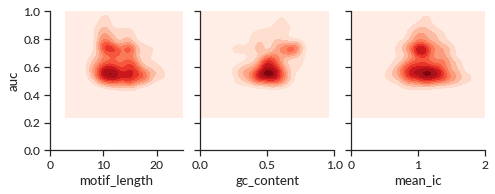

In [19]:
for dataset in ['remap', 'jy10', 'jy50']:
    df = pd.read_csv(f'results/{dataset}/motif_tf_aucs.{dataset}.tsv', sep='\t')
    g = sns.PairGrid(df, x_vars=['motif_length', 'gc_content', 'mean_ic'], y_vars=['auc'], aspect=0.9)
    for i in range(len(g.axes)):
        g.axes[0][i].set(ylim=(0,1))
    g.axes[0][0].set(xlim=(0,25))
    g.axes[0][1].set(xlim=(0,1))
    g.axes[0][2].set(xlim=(0,2))
    g.map(sns.kdeplot, shade=True, cmap='Reds');
    g.savefig(f"{dataset}_distplot.same_tf.svg", dpi=300)

In [9]:
def logpval(pvalue):
    if pvalue > 0:
        return -log10(pvalue)
    return 1000
    
correlations = {'same_tf': {}, 'all': {}}
pvalues = {'same_tf': {}, 'all': {}}
slopes = {'same_tf': {}, 'all': {}}
r2s =  {'same_tf': {}, 'all': {}}
for dataset in ['remap', 'jy10', 'jy50', 'uniprobe']:
    for dataset_type in ['same_tf', 'all']:
        correlations[dataset_type][dataset] = {}
        pvalues[dataset_type][dataset] = {}
        slopes[dataset_type][dataset] = {}
        r2s[dataset_type][dataset] = {}

features = ['motif_length', 'gc_content', 'mean_ic']



for dataset in ['remap', 'jy10', 'jy50', 'uniprobe']:
    # for uniprobe `auc` is actually `correlation`
    target_var = 'auc'

    analysis_configs = {
        'same_tf': f'results/{dataset}/motif_tf_aucs.{dataset}.tsv',
        'all': f'results/{dataset}/motif_tf_aucs.all.{dataset}.tsv',
    }
    for (dataset_type, fn) in analysis_configs.items():
        df = pd.read_csv(fn, sep='\t')
        for feature in features:
            corr, pval = scipy.stats.pearsonr(df[target_var], df[feature])
            correlations[dataset_type][dataset][feature] = round(corr, 3)
            pvalues[dataset_type][dataset][feature] = round(logpval(pval), 3)

            xs = np.array(df[feature]).reshape(-1,1)
            ys = np.array(df[target_var])
            model = sklearn.linear_model.LinearRegression(fit_intercept=True)
            model.fit(xs, ys)
            
            slopes[dataset_type][dataset][feature] = round(model.coef_[0], 3)
            r2s[dataset_type][dataset][feature] = round(model.score(xs, ys), 3)


In [10]:
# slopes
# r2s

{'same_tf': {'remap': {'motif_length': 0.001,
   'gc_content': 0.054,
   'mean_ic': 0.016},
  'jy10': {'motif_length': 0.015, 'gc_content': 0.053, 'mean_ic': 0.008},
  'jy50': {'motif_length': 0.026, 'gc_content': 0.032, 'mean_ic': 0.005},
  'uniprobe': {'motif_length': 0.217, 'gc_content': 0.169, 'mean_ic': 0.048}},
 'all': {'remap': {'motif_length': 0.001, 'gc_content': 0.123, 'mean_ic': 0.0},
  'jy10': {'motif_length': 0.0, 'gc_content': 0.013, 'mean_ic': 0.0},
  'jy50': {'motif_length': 0.0, 'gc_content': 0.009, 'mean_ic': 0.0},
  'uniprobe': {'motif_length': 0.047, 'gc_content': 0.479, 'mean_ic': 0.005}}}

In [11]:
print(f'=====================CORRELATIONS========================')
for dataset_type in ['same_tf', 'all']:
    print(f'\n-------------{dataset_type}-----------------')
    print('dataset', *features, sep='\t')
    for dataset in ['remap', 'jy50', 'jy10', 'uniprobe']:
        corr_row = [correlations[dataset_type][dataset][feature] for feature in features]
        print(dataset, *corr_row, sep ='\t')
print(f'\n\n========================PVALUES===========================')
for dataset_type in ['same_tf', 'all']:
    print(f'\n-------------{dataset_type}-----------------')
    print('dataset', *features, sep='\t')
    for dataset in ['remap', 'jy50', 'jy10', 'uniprobe']:
        pvalues_row = [pvalues[dataset_type][dataset][feature] for feature in features]
        print(dataset, *pvalues_row, sep ='\t')

#####################################################

for dataset_type in ['same_tf', 'all']:
    with open(f'motif_feature_correlations/motif_feature_correlations.{dataset_type}.corr.tsv', 'w') as fw:
        print('dataset', *features, sep='\t', file=fw)
        for dataset in ['remap', 'jy50', 'jy10', 'uniprobe']:
            corr_row = [correlations[dataset_type][dataset][feature] for feature in features]
            print(dataset, *corr_row, sep ='\t', file=fw)

    with open(f'motif_feature_correlations/motif_feature_correlations.{dataset_type}.pval.tsv', 'w') as fw:
        print('dataset', *features, sep='\t', file=fw)
        for dataset in ['remap', 'jy50', 'jy10', 'uniprobe']:
            pvalues_row = [pvalues[dataset_type][dataset][feature] for feature in features]
            print(dataset, *pvalues_row, sep ='\t', file=fw)

    with open(f'motif_feature_correlations/motif_feature_correlations.{dataset_type}.slope.tsv', 'w') as fw:
        print('dataset', *features, sep='\t', file=fw)
        for dataset in ['remap', 'jy50', 'jy10', 'uniprobe']:
            row = [slopes[dataset_type][dataset][feature] for feature in features]
            print(dataset, *row, sep ='\t', file=fw)
    
    with open(f'motif_feature_correlations/motif_feature_correlations.{dataset_type}.r2.tsv', 'w') as fw:
        print('dataset', *features, sep='\t', file=fw)
        for dataset in ['remap', 'jy50', 'jy10', 'uniprobe']:
            row = [r2s[dataset_type][dataset][feature] for feature in features]
            print(dataset, *row, sep ='\t', file=fw)


=====================CORRELATIONS========================

-------------same_tf-----------------
dataset	motif_length	gc_content	mean_ic
remap	-0.032	0.233	-0.127
jy50	-0.16	0.178	-0.074
jy10	-0.124	0.229	-0.089
uniprobe	-0.466	-0.411	-0.218

-------------all-----------------
dataset	motif_length	gc_content	mean_ic
remap	-0.032	0.35	0.002
jy50	-0.004	0.093	-0.008
jy10	0.015	0.115	-0.014
uniprobe	-0.218	-0.692	-0.067


========================PVALUES===========================

-------------same_tf-----------------
dataset	motif_length	gc_content	mean_ic
remap	0.523	13.716	4.462
jy50	6.747	8.187	1.787
jy10	4.263	13.304	2.402
uniprobe	23.597	18.001	5.258

-------------all-----------------
dataset	motif_length	gc_content	mean_ic
remap	122.453	1000	0.711
jy50	2.779	1000	9.023
jy10	28.043	1000	23.401
uniprobe	1000	1000	1000


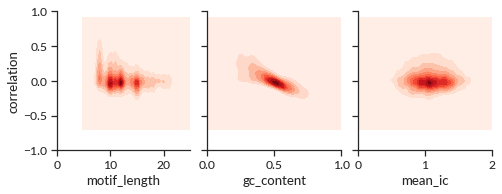

In [7]:
df = pd.read_csv('results/uniprobe/motif_tf_aucs.all.uniprobe.tsv', sep='\t')
df.columns = ['correlation', 'motif_length', 'gc_content', 'mean_ic']

g = sns.PairGrid(df, x_vars=['motif_length', 'gc_content', 'mean_ic'], y_vars=['correlation'], aspect=0.9)
for i in range(len(g.axes)):
    g.axes[0][i].set(ylim=(-1,1))
g.axes[0][0].set(xlim=(0,25))
g.axes[0][1].set(xlim=(0,1))
g.axes[0][2].set(xlim=(0,2))
g.map(sns.kdeplot, shade=True, cmap='Reds');
g.savefig(f"uniprobe_distplot.all.svg", dpi=300)

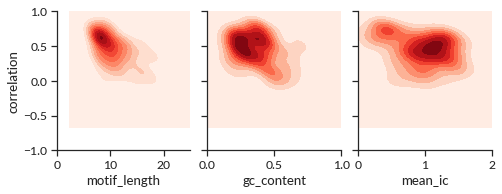

In [6]:
df = pd.read_csv('results/uniprobe/motif_tf_aucs.uniprobe.tsv', sep='\t')
df.columns = ['correlation', 'motif_length', 'gc_content', 'mean_ic']

g = sns.PairGrid(df, x_vars=['motif_length', 'gc_content', 'mean_ic'], y_vars=['correlation'], aspect=0.9)
for i in range(len(g.axes)):
    g.axes[0][i].set(ylim=(-1,1))
g.axes[0][0].set(xlim=(0,25))
g.axes[0][1].set(xlim=(0,1))
g.axes[0][2].set(xlim=(0,2))
g.map(sns.kdeplot, shade=True, cmap='Reds');
g.savefig(f"uniprobe_distplot.same_tf.svg", dpi=300)

In [14]:
# import scipy.stats

# print('same_tf')
# df = pd.read_csv('results/uniprobe/motif_tf_aucs.uniprobe.tsv', sep='\t')
# df.columns = ['correlation', 'motif_length', 'gc_content', 'mean_ic']
# for feature in ['motif_length', 'gc_content', 'mean_ic']:
#     corr, pval = scipy.stats.pearsonr(df['correlation'], df[feature])
#     print(feature, corr, pval)

# print('---------------')
# print('all')
# df = pd.read_csv('results/uniprobe/motif_tf_aucs.all.uniprobe.tsv', sep='\t')
# df.columns = ['correlation', 'motif_length', 'gc_content', 'mean_ic']
# for feature in ['motif_length', 'gc_content', 'mean_ic']:
#     corr, pval = scipy.stats.pearsonr(df['correlation'], df[feature])
#     print(feature, corr, pval)

same_tf
motif_length -0.4662371037423059 2.5273990732442652e-24
gc_content -0.4107279264829243 9.979655636357983e-19
mean_ic -0.21838668220099045 5.523366682333584e-06
---------------
all
motif_length -0.21752136952687018 0.0
gc_content -0.6918461466079386 0.0
mean_ic -0.06734139733970063 0.0


In [ ]:
df = pd.read_csv('auc_delta_infos.tsv', sep='\t')
# print(df.head())
df = df[df.auc != 0]
# df_best = df[df.delta_type == 'best_in_family_delta']
df_best = df[df.delta_type == 'representative_delta:0']
sns.distplot(df_best['auc'])
# df_best.count()

{'Forkhead box (FOX) factors{3.3.1}', 'Three-zinc finger Krüppel-related factors{2.3.1}', 'Ets-related factors{3.5.2}', 'Factors with multiple dispersed zinc fingers{2.3.4}'}
{'proper_tf:IKZF1', 'representative:11:MA0138.2_REST', 'representative:10:PRDM4_HUMAN.H11MO.0.D', 'representative:12:ZN382_HUMAN.H11MO.0.C', 'representative:2:ZBTB4_HUMAN.H11MO.0.D', 'proper_tf:MAZ', 'representative:5:ZN784_HUMAN.H11MO.0.D', 'representative:3:HINFP_HUMAN.H11MO.0.C', 'representative:14:EVI1_HUMAN.H11MO.0.B', 'representative:4:ZN335_HUMAN.H11MO.0.A', 'representative:6:MA0073.1_RREB1', 'all', 'representative:7:ZN134_HUMAN.H11MO.0.C', 'proper_tf:BCL11A', 'representative:9:MA0116.1_Znf423', 'proper_tfs', 'representative:1:ZBTB4_HUMAN.H11MO.1.D', 'best_overall', 'representative:0:ZN467_HUMAN.H11MO.0.C', 'representative:8:ZN418_HUMAN.H11MO.1.D', 'representative:13:ZNF8_HUMAN.H11MO.0.C', 'best_representative', 'all_representatives', 'best_in_family'}


/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/ilya/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


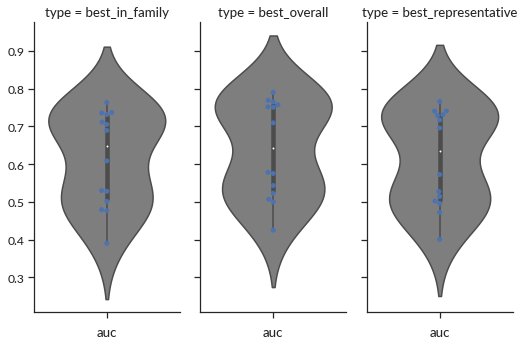

In [4]:
# sns.violinplot
df = pd.read_csv('auc_infos_by_family.tsv',sep='\t')
df.head()
print(set(df.family))
# df = df[df.family == 'Ets-related factors{3.5.2}']
# df = df[df.family == 'Three-zinc finger Krüppel-related factors{2.3.1}']
df = df[df.family == 'Factors with multiple dispersed zinc fingers{2.3.4}']
# df = df[df.family == 'Forkhead box (FOX) factors{3.3.1}']
print(set(df.type))
# sns.violinplot(df, orient='vertical',col='type')
# df = df[df.type.isin(['all', 'best_in_family', 'best_overall', 'representative:0', 'proper_tfs'])]
df = df[df.type.isin(['best_in_family', 'best_overall', 'best_representative', 'proper_tfs', 'representative:0', 'representative:1',])]
df = df[df.type.isin(['best_in_family', 'best_overall', 'best_representative', 'representative:0', 'representative:1',])]
g = sns.FacetGrid(df, col="type",height=5, aspect=0.5)
g.map(sns.violinplot, "auc", orient = 'v', saturation=0)
g.map(sns.swarmplot, "auc", orient = 'v')
# g.add_legend();

In [ ]:
df = pd.read_csv('tf_families_heatmap.tsv', sep='\t',index_col=0)
g = sns.heatmap(df,vmin=0.5, vmax = 1, linewidths=.25, linecolor='darkgray',cmap='YlOrRd')
g = g.get_figure()
g.tight_layout()
g.savefig(f"heatmap_classes.svg", dpi=300)

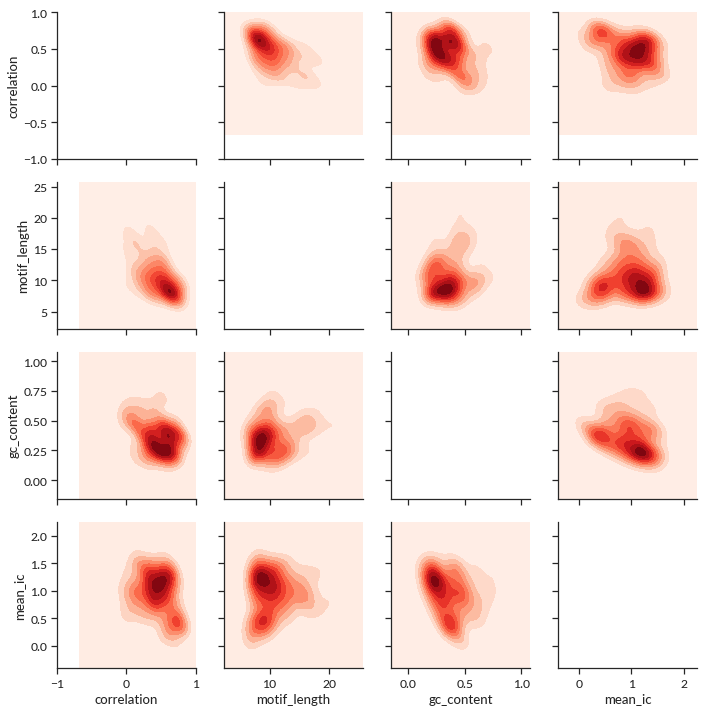

In [18]:
df = pd.read_csv('results/uniprobe/motif_tf_aucs.uniprobe.tsv', sep='\t')
df.columns = ['correlation', 'motif_length', 'gc_content', 'mean_ic']

g = sns.PairGrid(df)
# g.map_diag(sns.kdeplot)
for i in range(len(g.axes)):
    g.axes[0][i].set(ylim=(-1,1))
    g.axes[i][0].set(xlim=(-1,1))
g.map_offdiag(sns.kdeplot, shade=True, cmap='Reds');
g.savefig(f"uniprobe_distplot.svg", dpi=300)

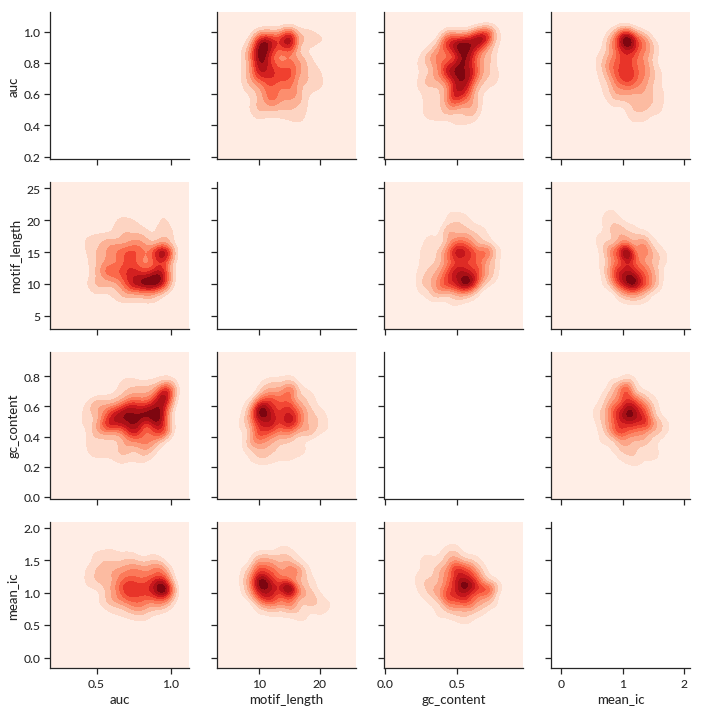

In [19]:
df = pd.read_csv('results/remap/motif_tf_aucs.remap.tsv', sep='\t')

g = sns.PairGrid(df)
# g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, shade=True, cmap='Reds');
g.savefig(f"remap_distplot.svg", dpi=300)

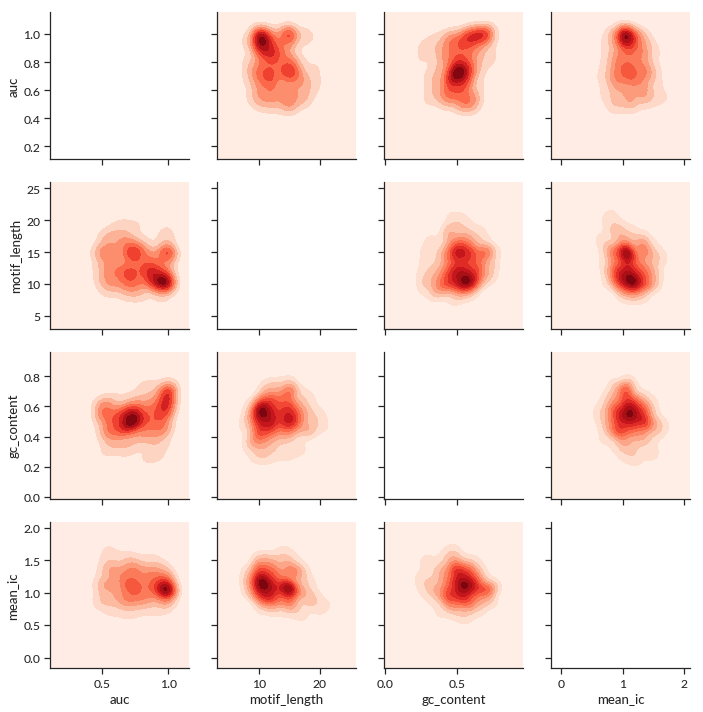

In [15]:
df = pd.read_csv('results/jy10/motif_tf_aucs.jy10.tsv', sep='\t')

g = sns.PairGrid(df)
# g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, shade=True, cmap='Reds');
g.savefig(f"jy10_distplot.svg", dpi=300)

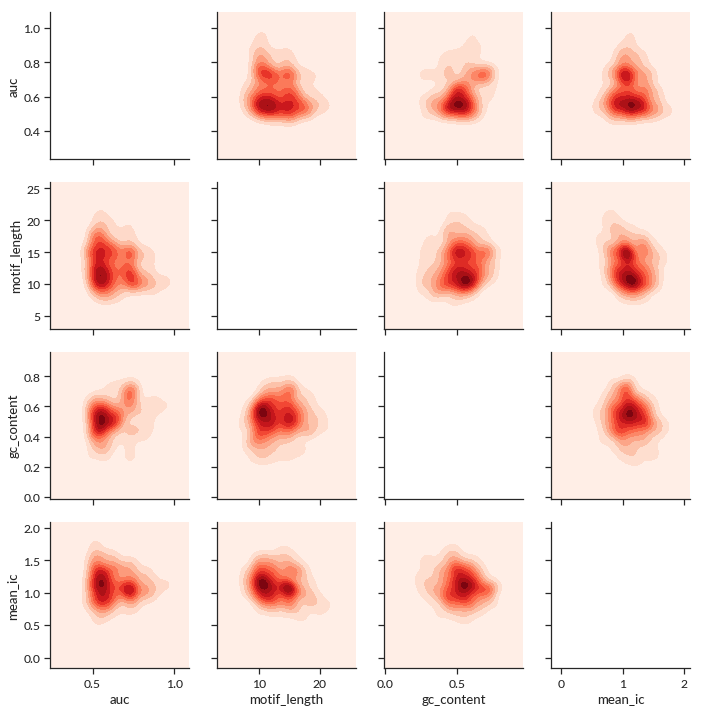

In [16]:
df = pd.read_csv('results/jy50/motif_tf_aucs.jy50.tsv', sep='\t')

g = sns.PairGrid(df)
# g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, shade=True, cmap='Reds');
g.savefig(f"jy50_distplot.svg", dpi=300)